In [2]:
import pandas as pd
import numpy as np
from sdv.single_table import CTGANSynthesizer

rpad_df = pd.read_excel(r'RPAD_data.xlsx', engine='openpyxl')
print(rpad_df.shape)
#print(rpad_df.head(10))

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(782, 58)


In [3]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=rpad_df)

In [4]:
import ray

@ray.remote
def make_prediction(model, sample_size):
    #df = pq.read_table(shard_path).to_pandas()
    result = model(sample_size)

    # Write out the prediction result.
    # NOTE: unless the driver will have to further process the
    # result (other than simply writing out to storage system),
    # writing out at remote task is recommended, as it can avoid
    # congesting or overloading the driver.
    # ...

    # Here we just return the size about the result in this example.
    return len(result)

# 12 files, one for each remote task.
input_files = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

# ray.put() the model just once to local object store, and then pass the
# reference to the remote tasks.
# load synthesizer
model_ref = ray.put(model)

result_refs = []

# Launch all prediction tasks.
for file in input_files:
    # Launch a prediction task by passing model reference and shard file to it.
    # NOTE: it would be highly inefficient if you are passing the model itself
    # like make_prediction.remote(model, file), which in order to pass the model
    # to remote node will ray.put(model) for each task, potentially overwhelming
    # the local object store and causing out-of-disk error.
    result_refs.append(make_prediction.remote(model_ref, file))

results = ray.get(result_refs)

# Let's check prediction output size.
for r in results:
    print("Prediction output size:", r)

KeyboardInterrupt: 

In [6]:
model = CTGANSynthesizer(metadata, epochs = 500)
model.fit(rpad_df)   

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Age'. Data will not be rounded.
  warnings.warn(
/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'BMI'. Data will not be rounded.
  warnings.warn(


time needed for preprocessing: -76.20801901817322


In [5]:
new_data = model.sample(num_rows=1000000) #200
print(new_data.shape)
# to generate sample of 1 million -> 1 min 40 sek



(1000000, 58)


In [3]:
#model.save('rpad_ep500_dsteps5.pkl')
model = CTGANSynthesizer.load('rpad_ep500_dsteps5.pkl')
#model = CTGANSynthesizer.load('rpad_custom_c_ep500_dsteps5.pkl')

In [47]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    rpad_df,
    new_data,
    metadata
)

# Default: overall: 79% col shapes 82.34% col pair 75.69%
# Neue Params -> 84.04% 87.7% 80.38% (discriminator steps 5 500 epochs wenn sampling auf 300 gesetzt wird) 
# sonst wenn sample bei 200 bleibt 2% wneiger gute scores

# custom constraints: 86.85%, 89.14%; 84.55%
# custom and positive constraints 1000 epochs and 100 sample size: 88.47; 89.01; 87.93

Creating report: 100%|██████████| 4/4 [00:00<00:00, 26.30it/s]



Overall Quality Score: 88.47%

Properties:
Column Shapes: 89.01%
Column Pair Trends: 87.93%


In [48]:
quality_report.get_visualization('Column Shapes')

In [50]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=rpad_df,
    synthetic_data=new_data,
    column_name='Length_of_Stay',
    metadata=metadata
)
    
fig.show()
fig.write_image(file = 'Length_of_Stay_metadata_custom_c_ep1000_dsteps5.png')


In [51]:
# Diagnostic report Zeigen:
from sdmetrics.reports.single_table import DiagnosticReport

dg_report = DiagnosticReport()
dg_report.generate(rpad_df, new_data, metadata, verbose=True)
# default model: over 90% -> one warning missing more than 10% of numerical ranges
# larger model: no problems
# mit positive constraints und 1000 eochs -> warning missing more than 10% of numerical ranges

Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [53]:
# plot two variables:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=rpad_df,
    synthetic_data=new_data,
    column_names=['Severity', 'Management'],
    metadata=metadata)
    
fig.show()
#fig.write_image(file = 'Severity_Management_custom_c_ep1000_dsteps5.png')

In [9]:
#new_data = pd.read_csv("/home/antonia/code/Unlocking-Information/synthetic_rpad_ep500_ds5.csv")

In [12]:
print(rpad_df.isna().sum())
print(rpad_df.shape)
rpad_df.dropna(inplace=True)
print(rpad_df.shape)

ID                                0
Age                               1
BMI                              27
Sex                               2
Height                           26
Weight                            3
Length_of_Stay                    4
Management                        1
Severity                          1
Alvarado_Score                   52
Paedriatic_Appendicitis_Score    52
dtype: int64
(782, 11)
(705, 11)


In [19]:
print(new_data.isna().sum())
print(new_data.shape)
new_data.dropna(inplace=True)
print(new_data.shape)

ID                                0
Age                               1
BMI                              20
Sex                              70
Height                           18
Weight                            4
Length_of_Stay                    4
Management                       37
Severity                         56
Alvarado_Score                   47
Paedriatic_Appendicitis_Score    47
dtype: int64
(700, 11)
(525, 11)


In [54]:
from sdmetrics.single_table import BNLikelihood


BNLikelihood.compute(
    real_data=rpad_df,
    synthetic_data=new_data,
    metadata=metadata
)
# 500 -> 0.17 -> schlechter ^^
# 1000 + positive constraints -< besser 0.18

0.1860202749239786

In [55]:
from sdmetrics.single_table import GMLogLikelihood

GMLogLikelihood.compute(
    real_data=rpad_df,
    synthetic_data=new_data
)


-30.67936074947661

In [58]:
from sdmetrics.single_table import LogisticDetection

LogisticDetection.compute(
    real_data=rpad_df,
    synthetic_data=new_data,
    metadata=metadata
)

0.04953947318600738

In [59]:
from sdmetrics.single_table import SVCDetection

SVCDetection.compute(
    real_data=rpad_df ,
    synthetic_data=new_data,
    metadata=metadata
)

0.04002070131539581

In [4]:
# Add custom constraints:
# check constraints on real data -> check all true!
#def is_valid(data, column_names=["BMI", "weight", "height"]):
#    # replace with your custom logic
#    
#    validity = data['BMI'] == data['weight']/data['height']**2
#    return pd.Series(validity)
rpad_df['valid_check'] = round(rpad_df['BMI'],0) == round(rpad_df['Weight']/(rpad_df['Height']/100)**2,0)
#valid_check = rpad_df['BMI'] == rpad_df['Weight']/(rpad_df['Height']/100)**2

print(rpad_df['valid_check'].sum())
print(rpad_df.shape)



729
(782, 12)


In [5]:
rpad_df.drop(rpad_df[round(rpad_df['BMI'],0) != round(rpad_df['Weight']/(rpad_df['Height']/100)**2,0)].index, inplace=True)
rpad_df.drop(columns=['valid_check'], inplace=True)
print(rpad_df.shape)

(729, 11)


In [6]:
def is_valid(column_names, data):
    # replace with your custom logic
    bmi_column = data[column_names[0]]
    weight_column = data[column_names[1]]
    height_column = data[column_names[2]]
    true_values = round(bmi_column,0) == round(weight_column/round(height_column/100)**2,0)
    false_values = round(bmi_column,0) != round(weight_column/round(height_column/100)**2,0)
    return (true_values) | (false_values)
print(is_valid(["BMI", "Weight", "Height"], rpad_df))

0      True
1      True
2      True
3      True
4      True
       ... 
777    True
778    True
779    True
780    True
781    True
Length: 729, dtype: bool


In [25]:
rpad_df.columns

Index(['ID', 'Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Management', 'Severity', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score'],
      dtype='object')

In [34]:
positive_bmi = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'BMI',
        'strict_boundaries': True
    }
}

positive_weight = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Weight',
        'strict_boundaries': True
    }
}

positive_height = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Height',
        'strict_boundaries': True
    }
}

positive_los = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Length_of_Stay',
        'strict_boundaries': True
    }
}

positive_age = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Age',
        'strict_boundaries': False
    }
}

positive_a_score = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Alvarado_Score',
        'strict_boundaries': False
    }
}

positive_pa_score = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Paedriatic_Appendicitis_Score',
        'strict_boundaries': False
    }
}

In [41]:
# load the constraint from the file
model = CTGANSynthesizer(metadata, discriminator_steps=5, epochs = 1000)
model.load_custom_constraint_classes(
    filepath='/home/antonia/code/Unlocking-Information/example_custom_constraint.py',
    class_names=['MyCustomConstraintClass']
)

constraint = {
    'constraint_class': 'MyCustomConstraintClass',
    'constraint_parameters': {
        'column_names': ['BMI', 'Weight', 'Height']
    }
}


In [42]:

#constraint.keys()
model.add_constraints([constraint, positive_bmi, positive_weight, positive_height, positive_los, positive_age, positive_a_score, positive_pa_score])

In [43]:
model.fit(rpad_df)
# mit vielen constraints und 500 epochen werden quality score schlechter

<sdv.constraints.tabular.create_custom_constraint_class.<locals>.CustomConstraint object at 0x7f6ba064c190>


In [44]:
model.save('rpad_custom_c_plus_ep1000_dsteps5.pkl')

In [38]:
from sdmetrics.single_table import LinearRegression, MLPRegressor
# no nans
#rpad_df.dropna(inplace=True) radio buttons mit options

#rpad_df.drop(columns=['ID'], inplace=True)
#new_data.dropna(inplace=True)
#new_data.drop(columns=['ID'], inplace=True)
#
#rpad_df = rpad_df[['Weight', 'Height', 'BMI']]
#new_data = new_data[['Weight', 'Height', 'BMI']]
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=rpad_df)

MLPRegressor.compute(
    test_data=rpad_df,
    train_data=rpad_df,
    target='BMI',
    metadata=metadata
)

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



-7.143136310602246

In [ ]:
new_data

In [ ]:
from sdmetrics.single_table import BinaryAdaBoostClassifier, BinaryDecisionTreeClassifier, BinaryLogisticRegression, BinaryMLPClassifier    

BinaryAdaBoostClassifier.compute(
    test_data=real_data,
    train_data=synthetic_data,
    target='boolean_column_name',
    metadata=metadata
)

#BinaryDecisionTreeClassifier.compute(
#    test_data=real_data,
#    train_data=synthetic_data,
#    target='boolean_column_name',
#    metadata=metadata
#)

In [20]:
from hotelling.stats import hotelling_dict
#str_col = ['Sex', 'Management', 'Severity']
rpad_df.drop(columns=str_col, inplace=True)
new_data.drop(columns=str_col, inplace=True)
test_dict = hotelling_dict(rpad_df, y=new_data, bessel=True)
print(test_dict)

{'t2_stat': 36.180475839317374, 'f_stat': 5.143344269863341, 'p_value': 8.79594023018864e-06, 'pooled_var': array([[ 15.35296095,   6.0975824 ,  45.1335684 ,  41.01492769,
         -0.96276395,  -1.41568461,  -0.65852183],
       [  6.0975824 ,  25.93634587,  41.31765225,  64.04215089,
         -1.40605916,  -1.1472927 ,  -0.68619992],
       [ 45.1335684 ,  41.31765225, 546.13697049, 264.28630769,
        -10.56526017,  -9.30573093,  -6.34054316],
       [ 41.01492769,  64.04215089, 264.28630769, 447.53322306,
         -5.31154054,  -5.85340909,  -6.1147548 ],
       [ -0.96276395,  -1.40605916, -10.56526017,  -5.31154054,
          7.5310535 ,   1.57369577,   1.03860677],
       [ -1.41568461,  -1.1472927 ,  -9.30573093,  -5.85340909,
          1.57369577,   4.51260252,   2.17058857],
       [ -0.65852183,  -0.68619992,  -6.34054316,  -6.1147548 ,
          1.03860677,   2.17058857,   3.71066199]])}


(705, 10)


/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:88: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify th

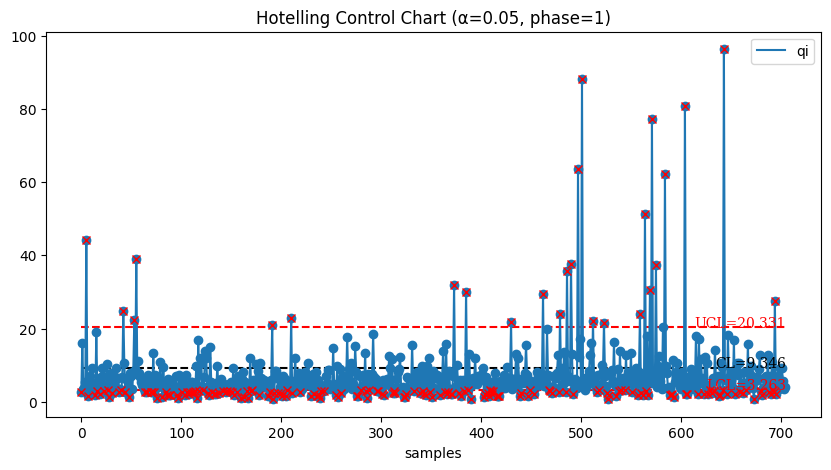

In [17]:
from hotelling.plots import control_chart, control_stats, univariate_control_chart
rpad_df.dropna(inplace=True)
#rpad_df.drop(columns=['ID'], inplace=True)
print(rpad_df.shape)
ax = control_chart(rpad_df, alpha=0.05, legend_right=True)



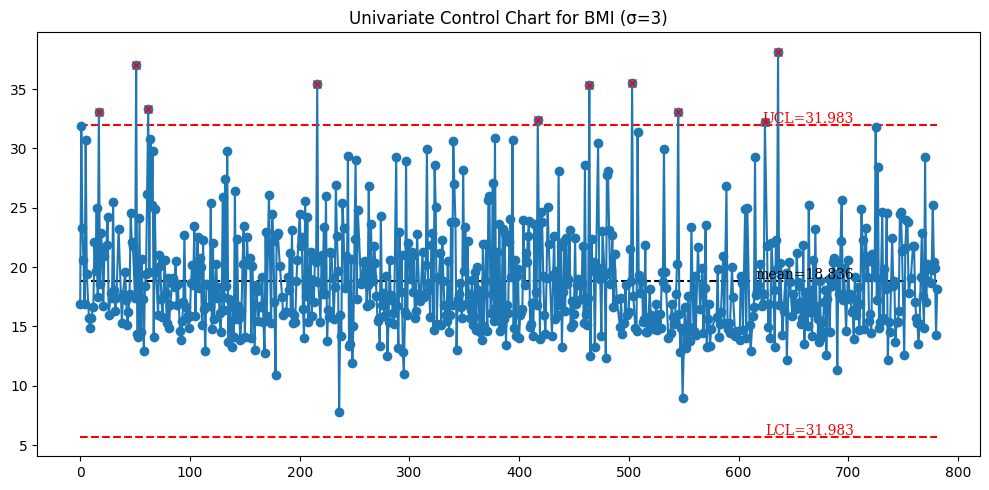

In [15]:
fig = univariate_control_chart(rpad_df[['BMI']], legend_right=True)

In [11]:
x_bar, s = control_stats(rpad_df)
x_bar

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:88: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/plots.py:90: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify th

Age                               11.284591
BMI                               18.835506
Height                           147.891206
Weight                            43.052071
Length_of_Stay                     4.225532
Alvarado_Score                     5.896454
Paedriatic_Appendicitis_Score      5.229787
dtype: float64

In [14]:


help(univariate_control_chart)



Help on function univariate_control_chart in module hotelling.plots:

univariate_control_chart(x, var=None, sigma=3, legend_right=False, interactive=False, connected=True, width=10, cusum=False, cusum_only=False, template='none', marker='o', ooc_marker='x', limit=1000, random_state=42, no_display=False)
    univariate_control_chart.
    
    :param x: dask or pandas dataframe, uni or multivariate
    :param var: optional, variable to plot (default to all)
    :param sigma: default to 3 sigma from mean for upper and lower control lines
    :param legend_right: default to 'left', can specify 'right'
    :param interactive: if plotly is available, renders as interactive plot in notebook. False to render image.
    :param connected: defaults to True. Appropriate when time related /consecutive batches, else, should be False
    :param width: how many units wide. defaults to 10, good for notebooks
    :param cusum: use cumulative sum instead of average
    :param cusum_only: don't display va

In [12]:
new_data.dropna(inplace=True)
print(new_data.shape)
new_data.drop(columns=['ID'], inplace=True)

(523, 11)


/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/home/antonia/anaconda3/envs/pycon_demo/lib/python3.10/site-packages/hotelling/stats.py:181: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_on

<AxesSubplot:title={'center':'Hotelling Control Chart (α=0.01, phase=2)'}, xlabel='samples'>

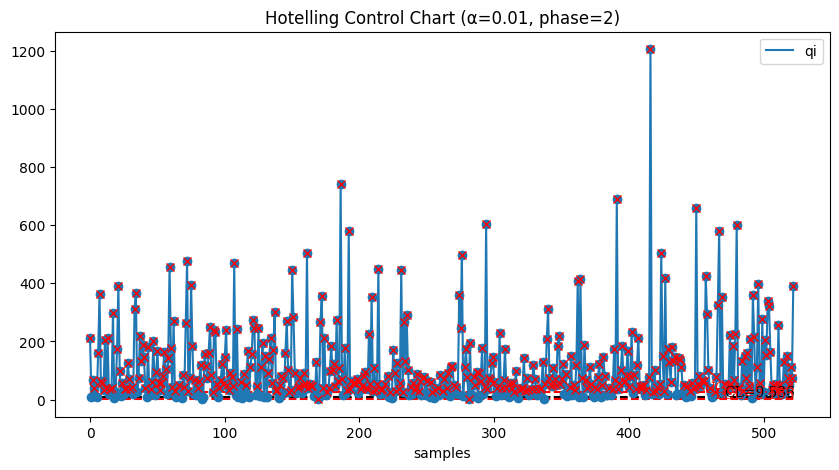

In [13]:
control_chart(new_data, alpha=0.01, phase=2, x_bar=x_bar, s=s, legend_right=True)

In [38]:
# Interpretiere above aussagen: -> wo muss näher reingeschaut werden + warum?
#import json

#with open('my_metadata_file.json', 'w') as f:
#    json.dump(metadata_coltypes, f)


#with open('my_metadata_file.json') as f:
#    metadata_coltypes = json.load(f)

# use my_metadata_dict in the SDMetrics library


# Bis hierhin sind essential steps die super in documentation nachgelesen werden können. -> hier tips und tricks erklären (zum mitcoden wenn möchten)
# danach wie verbesere ich es?

In [25]:
fig = univariate_control_chart(rpad_df[0:3])

ValueError: Single argument to subplot must be a three-digit integer, not 1111

<Figure size 1000x5500 with 0 Axes>

In [13]:
# Ab hier Qualitäts auswertung
# erwähnen dass für sowas wie namen ist es nicht relevant und sogar schlecht wenn überlappungen da sind 
# überlegen und erklären was namens columns für den quality report bedeuten 
# erstmal details ausgeben:
my_report.get_details(property_name='Column Shapes')
my_report.get_details(property_name='Column Pair Trends')
# explain output -> not very helpfull?


,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,first_name,last_name,ContingencySimilarity,2.000000e-03,NaN,NaN
1,company_name,first_name,ContingencySimilarity,2.000000e-03,NaN,NaN
2,address,first_name,ContingencySimilarity,2.000000e-03,NaN,NaN
3,city,first_name,ContingencySimilarity,2.000000e-03,NaN,NaN
4,county,first_name,ContingencySimilarity,8.000000e-03,NaN,NaN
5,first_name,postal,ContingencySimilarity,2.000000e-03,NaN,NaN
6,first_name,phone1,ContingencySimilarity,2.000000e-03,NaN,NaN
7,first_name,phone2,ContingencySimilarity,2.000000e-03,NaN,NaN
8,email,first_name,ContingencySimilarity,-2.220446e-16,NaN,NaN
9,first_name,web,ContingencySimilarity,2.000000e-03,NaN,NaN


In [14]:
fig = my_report.get_visualization(property_name='Column Shapes')
fig.show()

# ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed erklären?
# uU nötig: !pip install --upgrade nbformat
# explaining safe report and load ist möglich -> nicht zeigen sondern am ende erwähnen -> ist schon im tutorial drin

In [ ]:
# Die bige grafik erklären -> und drauf eingehenwie es verbessert werden kann 
# -> die verbesserung umsetzen und dann zeigen wie es sich verbessert

In [15]:
# Diagnostic report Zeigen:
from sdmetrics.reports.single_table import DiagnosticReport

dg_report = DiagnosticReport()
dg_report.generate(real_data, synthetic_data, metadata_coltypes)
# Explain output und wie du das verbessern kannst -> demonstrate die verbesserung
# als dirctionary speichern möglich


Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data

DANGER:
x The synthetic data is missing more than 50% of the categories present in the real data


In [ ]:
dg_report.get_details(property_name='Coverage')
# explain numbers:

In [17]:
fig = dg_report.get_visualization(property_name='Coverage')
fig.show()
# explain graf

In [ ]:
# Extra visualisierungen die angeboten werden (für numerische variablen)
from sdmetrics.reports import utils

fig = utils.get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    #column_names=['mba_perc', 'degree_perc'], # anpassen
    metadata=metadata_coltypes
    
)

fig.show()

In [20]:
# näher eingehen auf beta metrics -> utility metrics zB
# check ob aus kiss interessante sachen rausgeholt werden können.
# aus papern schauen was rausgeholt werden kann
# zeigen was aus table evaluator rauskommen kann -> zusammenhänge der apckages erklären 
# -> und zeigen statistsich nicht aber gute indikator und einfacher zu erklären vor kunden

# durchschnitt und standardabweichungen zeigen
# ähnlichkeit bei emails ausdenken/vergleichen


In [21]:
# !!! Hilfscell löschen in showcase nb!!!!
real_data.columns

Index(['first_name', 'last_name', 'company_name', 'address', 'city', 'county',
       'postal', 'phone1', 'phone2', 'email', 'web'],
      dtype='object')

In [26]:
# eigene comparison -> check ob das in sdv drin ist?
common_values_fn = set(real_data['first_name'].values).intersection(set(synthetic_data['first_name'].values))
common_values_ad = set(real_data['address'].values).intersection(set(synthetic_data['address'].values))
common_values_ph = set(real_data['phone1'].values).intersection(set(synthetic_data['phone1'].values))
print(len(real_data))
print(len(synthetic_data))
print(len(common_values_fn)) # interpretation not good
print(len(common_values_ad)) # interpretation not good
print(len(common_values_ph)) # interpretation not good
# show anonymize property and explain how it works ->
# alternative -> show how to use chatgpt for it??


500
200
166
166
168


In [32]:
# update:
model_an = CTGAN(anonymize_fields={
        'last_name': 'last_name', # name -> full person name -> aus faker seite feststellen es gibt auch last und first name -> auch female male nonbinary names etc
        'address': 'address'
        # maby use nonbinary firstname für die ertsen namen..
        
    })
model_an.fit(example_df,
             )
new_data_an = model_an.sample(num_rows=200)


In [33]:
common_values_ad = set(example_df['address'].values).intersection(set(new_data_an['address'].values))
common_values_ln = set(example_df['last_name'].values).intersection(set(new_data_an['last_name'].values))

print(len(common_values_ad)) # success
print(len(common_values_ln)) # success
print(new_data_an.head(10))

0
1
  first_name  last_name               company_name  \
0    Tamesha       Bond        Lasting Impressions   
1       Chan      Lopez  T J Ward & Associates Inc   
2   Isabelle      Lewis    Safeguard Chemical Corp   
3    Orville      Smith       Hughlett, Henry T Jr   
4     Carrol   Thompson     Danka Business Systems   
5   Mauricio    Sherman         Barr, Albert S Iii   
6       Ivan     Weaver       Morelli Hoskins Ford   
7     Martha       Kirk         Dale, George F Esq   
8     Shanda  Hernandez         Acc Automation Inc   
9        Val        Lee             Welders Supply   

                                             address  \
0          2506 Eric Throughway\nLake Erik, UT 35193   
1       330 Michael Rest\nEast Ronnieshire, TN 02822   
2             8803 Cesar Trace\nAmandabury, AL 01043   
3  5043 Felicia Orchard Apt. 226\nPort Anna, PA 6...   
4      2317 Scott Locks\nSouth Christopher, IL 57105   
5  05863 Silva Courts Apt. 708\nSamanthastad, NJ ...   
6        

In [ ]:
# create custom names mit chatgpt und Faker locale: 
# -> extra in notebook how to create custom name Faker locale zB for fantasy names mit chatgpt3
# warning: you have to tweak the package -> but no limits -> notebook vorbereiten



In [34]:
# vergleich neue daten reports
my_report_an = QualityReport()
my_report_an.generate(real_data, new_data_an, metadata_coltypes)
dg_report_an = DiagnosticReport()
dg_report_an.generate(real_data, new_data_an, metadata_coltypes)


Creating report:   0%|          | 0/4 [00:00<?, ?it/s]/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Bond in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Lopez in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Lewis in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Smith in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Thompson in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Sherman in synthetic data.

/home/antonia/.local/lib/python3.8/site-packages/sdmetrics/utils.py:67: UserWarning:

Unexpected value Weaver in synthetic data.

/home/antonia/.local/lib/python3.8/sit


Overall Quality Score: 15.28%

Properties:
Column Shapes: 30.41%
Column Pair Trends: 0.16%


Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data

DANGER:
x The synthetic data is missing more than 50% of the categories present in the real data


In [35]:
print(my_report.get_score())
print(my_report.get_properties())
print(dg_report.get_results())

print(my_report_an.get_score())
print(my_report_an.get_properties())
print(dg_report_an.get_results())
# zeigen wie scores bei categories sich verschlechtern -> trotzdem gibt es eine verteilung von namen? -> zumindest vergleich mails and und namen!
# -> formel für email definieren?


0.18680000000000047
             Property     Score
0       Column Shapes  0.371182
1  Column Pair Trends  0.002418
{'SUCCESS': ['Over 90% of the synthetic rows are not copies of the real data'], 'WARNING': [], 'DANGER': ['The synthetic data is missing more than 50% of the categories present in the real data']}
0.15284548624562544
             Property     Score
0       Column Shapes  0.304091
1  Column Pair Trends  0.001600
{'SUCCESS': ['Over 90% of the synthetic rows are not copies of the real data'], 'WARNING': [], 'DANGER': ['The synthetic data is missing more than 50% of the categories present in the real data']}


In [ ]:
# erwähnen das anpassen von hyperparameter möglich ist -> aber nicht showcasen
# conditional sampling erklären in einfach und wozu gut!
# untershciede zu copulas und andere generierungsfunktion dazu erklären

# andere daten suchen mit conditions (categories)
# hinweis to gaussian copula -> conditional sampling besser handeln -> aufnehmen in mind map



In [36]:
# handling constraints für zB Email -> oder andere beispiele:
from sdv.constraints import FixedCombinations

fixed_city_county_constraint = FixedCombinations(column_names=['city', 'county'])
constraints = [
    fixed_city_county_constraint
]

# update:
model_c = CTGAN(constraints = [
    fixed_city_county_constraint
    ], 
    #anonymize_fields={
    #    'last_name': 'last_name', # name -> full person name -> aus faker seite feststellen es gibt auch last und first name -> auch female male nonbinary names etc
    #    'address': 'address'
    #    # maby use nonbinary firstname für die ertsen namen..
    #    
    #}
    )
model_c.fit(example_df,
             )
new_data_an = model_c.sample(num_rows=200)

Sampling rows: 100%|██████████| 200/200 [00:00<00:00, 2875.43it/s]


In [46]:
# hat nicht funktioniert ... nochmal probieren
common_values_city = set(example_df['city'].values).intersection(set(new_data_an['city'].values))
print(common_values_city)
print(len(common_values_city)) # success
_combination_overlap = pd.merge(new_data_an[['city', 'county']], new_data[['city', 'county']], on=['city', 'county'], how='inner') 
_combination_overlap.shape

{'Speke-Garston Ward', 'Murdostoun Ward', 'Maybury and Sheerwater Ward', 'Addlestone Bourneside Ward', 'Renfrew South & Gallowhill War', 'Springfields and Trent Vale Wa', 'Lamport', 'New Milton', 'Hylands Ward', 'Cotham Ward', 'Gweek', 'Patching Hall Ward', 'Central Buchan Ward', 'Parr Ward', 'Boothen and Oak Hill Ward', 'Bishop Auckland', 'Astley Bridge Ward', 'Acton Trussell and Bednall', 'Wilsden', 'Longford Ward', 'Eccleshall', 'Yalding', 'Franche Ward', 'Hetton', 'Abbey Ward', 'Frimley Green Ward', 'Bulwell Ward', 'Little Parndon and Hare Street', 'Batchwood Ward', 'Selston', 'Windle Ward', 'Hollington Ward', 'Edmonton Green Ward', 'Wollaton West Ward', 'Iwade', 'Govan Ward', 'Bodmin', 'Aveton Gifford', 'Tanworth-in-Arden', 'Little Hereford', 'Redlands Ward', 'Walcot Ward', 'Hartshill', 'Hamilton South Ward', 'Shiney Row Ward', 'Southey Ward', 'North Horsham', 'Cleator Moor', 'Moulsham and Central Ward', 'Fareham South Ward', 'St. Stephens Ward', 'Meads Ward', 'Nonington', 'Market

(0, 2)

In [48]:
print(new_data.loc[new_data['city'] == 'Speke-Garston Ward'])
print(new_data_an.loc[new_data_an['city'] == 'Speke-Garston Ward'])

    first_name last_name            company_name                 address  \
147  Francisca   Nahmias  Matt Parrott & Sons Co  99 College St South #1   

                   city         county    postal        phone1        phone2  \
147  Speke-Garston Ward  County Durham  BA13 3QU  01964-503521  01567-215689   

                      email                                web  
147  elsa_delisle@gmail.com  http://www.kennedyscalesinc.co.uk  
   first_name last_name      company_name         address                city  \
57  Margarita     Heier  Smith & Dekay Ps  476 Starkie St  Speke-Garston Ward   

        county    postal        phone1        phone2  \
57  Merseyside  TN23 4GF  01630-202053  01221-177854   

                        email                                     web  
57  cherelle_sorrel@gmail.com  http://www.mitchellsillimancoinc.co.uk  


In [38]:
new_data[['city', 'county']]

,city,county
0,Foleshill Ward,Stirling
1,Newquay,Cumbria
2,Tiffield,Buckinghamshire
3,Ravenshead,South Gloucestershire
4,Corporation Park Ward,Derbyshire
...,...,...
195,Hexham,Surrey
196,"Neilston, Uplawmoor and Newton",Buckinghamshire
197,Everton Ward,Greater London
198,Holbrook,Suffolk
